# scikit-learn中的PCA使用

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 构造的数据中使用PCA

In [2]:
X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:,0] + 3. + np.random.normal(0, 10., size=100)

In [3]:
from sklearn.decomposition import PCA

In [4]:
pca = PCA(n_components=1) # 得到第1主成分
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
pca.components_ # 和我们自己封装的方法得到的向量刚好相反，不过不用担心，结果是不影响地

array([[-0.77989651, -0.62590849]])

In [6]:
X_reduction = pca.transform(X) # 使用第1主成分把原始数据降维到1维

In [7]:
X_reduction.shape

(100, 1)

In [8]:
X_restore = pca.inverse_transform(X_reduction)

In [9]:
X_restore.shape

(100, 2)

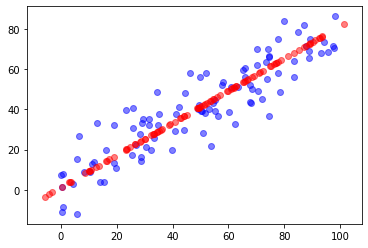

In [10]:
'''数据绘制,可以看出降维会导致数据丢失，还原(inverse)也没用，还原后的X_restore实际是第1主成分'''
plt.axis('on')
plt.scatter(X[:,0], X[:,1], color='b', alpha=0.5)
plt.scatter(X_restore[:,0], X_restore[:,1], color='r', alpha=0.5)
plt.show()

## 真实数据中使用PCA

In [11]:
from sklearn import datasets

In [12]:
digits = datasets.load_digits()

In [13]:
X = digits.data
y = digits.target

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [16]:
X_train.shape

(1347, 64)

### 1.K近邻算法

In [17]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

Wall time: 9.97 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
knn_clf.score(X_test, y_test)

0.9866666666666667

### 2.PCA进行降维后,再重新用kNN训练耗时会减少很多,但是精度也随之下降

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2) # 降到2维
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test) # 测试数据集上必须用训练数据建立好的模型，不能自己再重新PCA了

In [21]:
%%time
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train) # 可以看到耗时大幅度降低

Wall time: 998 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
knn_clf.score(X_test_reduction, y_test) # 降维会降低准确度，我们把64维(因为有64列)降到2维优点降地过了，可以适当增加维度，怎么选择合适的降维维度见下面方法

0.6066666666666667

## 如何选取合适的降维维度
### 可解释的方差比例

In [23]:
pca.explained_variance_ratio_ # 可解释的方差比例，能推导出合适的降到的维度

array([0.14566817, 0.13735469])

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
pca.explained_variance_ratio_

array([1.45668166e-01, 1.37354688e-01, 1.17777287e-01, 8.49968861e-02,
       5.86018996e-02, 5.11542945e-02, 4.26605279e-02, 3.60119663e-02,
       3.41105814e-02, 3.05407804e-02, 2.42337671e-02, 2.28700570e-02,
       1.80304649e-02, 1.79346003e-02, 1.45798298e-02, 1.42044841e-02,
       1.29961033e-02, 1.26617002e-02, 1.01728635e-02, 9.09314698e-03,
       8.85220461e-03, 7.73828332e-03, 7.60516219e-03, 7.11864860e-03,
       6.85977267e-03, 5.76411920e-03, 5.71688020e-03, 5.08255707e-03,
       4.89020776e-03, 4.34888085e-03, 3.72917505e-03, 3.57755036e-03,
       3.26989470e-03, 3.14917937e-03, 3.09269839e-03, 2.87619649e-03,
       2.50362666e-03, 2.25417403e-03, 2.20030857e-03, 1.98028746e-03,
       1.88195578e-03, 1.52769283e-03, 1.42823692e-03, 1.38003340e-03,
       1.17572392e-03, 1.07377463e-03, 9.55152460e-04, 9.00017642e-04,
       5.79162563e-04, 3.82793717e-04, 2.38328586e-04, 8.40132221e-05,
       5.60545588e-05, 5.48538930e-05, 1.08077650e-05, 4.01354717e-06,
      

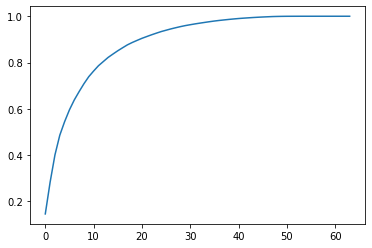

In [25]:
'''可以看出降维的降到的维度数对整体数据的保留比是多少'''
plt.plot([i for i in range(X_train.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(X_train.shape[1])])
plt.show()

### 传入要保留的数据占总数据的比例，然后训练好的模型的n_components_属性就是合适的降维维度数
> 一般想保留的原始数据越少，降维后的维度数越小；想保留的原始数据越多，降维后的数据维度数越大

In [26]:
'''需要保留95%的数据'''
pca = PCA(0.95) # 我们不需要传入要降到的维度数，只需要传入需要保留的原始数据比例即可。
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pca.n_components_ # 只用28个维度就能保留95%的数据。一般想保留的数据越小，降维后的维度数越小；想保留的数据越大，降维后的数据维度数越大

28

In [28]:
'''重新更新训练和测试数据'''
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [29]:
%%time 
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

Wall time: 997 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [30]:
knn_clf.score(X_test_reduction, y_test) # 准确度几乎不受影响

0.98

## 数据降到2维使用PCA对数据进行降维可视化
> 一个维度数较大(列数较多)的数据集降到2维虽然保留下的原始数据比例较小，但是有个重要的用途就是方便可视化了

In [31]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduction = pca.transform(X)

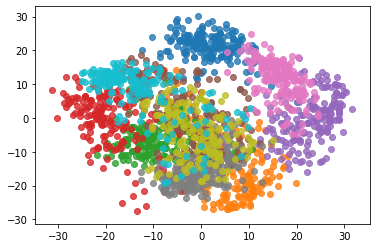

In [32]:
for i in range(10):
    plt.scatter(X_reduction[y==i,0], X_reduction[y==i,1], alpha=0.8) # y==i表示不同的类别，利用fancy indexing取出当前分类对应的在数据集中的行
plt.show()